In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 10000
sizeBatch = 32
layerDense = [256, 64, 16, 2]
layerDis = [512, 256]
dimOneHot = 10
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'
# nameOptim = Adam(0.0002, 0.5)

## Load the datasets

In [3]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
# xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
# xTest = (xTest.astype(np.float32) - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


In [4]:
inputsDis = Input(shape=(dimEncode,))
x = inputsDis
for numFilt in layerDis:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
validityDis = Dense(1, activation="sigmoid")(x)
discriminator = Model(inputsDis, validityDis, name='discriminator')
discriminator.compile(loss='binary_crossentropy',
                      optimizer=nameOptim,
                      metrics=['accuracy'])
discriminator.trainable = False

In [5]:
inpOneHot = Input(shape=(dimOneHot,))
x = inpOneHot
for numFilt in layerDis:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
validOneHot = Dense(1, activation="sigmoid")(x)
disOneHot = Model(inpOneHot, validOneHot, name='discriminatorOneHot')
disOneHot.compile(loss='binary_crossentropy',
                      optimizer=nameOptim,
                      metrics=['accuracy'])
disOneHot.trainable = False

In [6]:
discriminator.summary()
disOneHot.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 266,242
Trainable params: 133,121
Non-trainable params: 133,121
________________________________________________________________

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## Construct the encoder and decoder

In [7]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense[:-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
encode = Dense(dimEncode)(x)
encodeOneHot = Dense(dimOneHot, activation='softmax')(x)
encoder = Model(inputs, encode, name='encoder')
encoderOneHot = Model(inputs, encodeOneHot, name='encoderOneHot')

inputLatent = Input(shape=(dimEncode,))
inputOneHot = Input(shape=(dimOneHot,))
merged = concatenate([inputLatent, inputOneHot], axis=-1)
x = merged
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Dense(dimInput, activation='tanh')(x)
decoder = Model([inputLatent, inputOneHot], x, name='decoder')

encoder.summary()
encoderOneHot.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16)                0         
__________

## Construct the autoencoder

In [8]:
autoencoder = Model(inputs, [decoder([encoder(inputs), encoderOneHot(inputs)]), 
                             discriminator(encoder(inputs)), 
                             disOneHot(encoderOneHot(inputs))])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            218482      input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
encoderOneHot (Model)           (None, 10)           218618      input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (M

## Compile and train

In [41]:
autoencoder.compile(optimizer=nameOptim, 
                    loss=['mse', 'binary_crossentropy', 'binary_crossentropy'], 
                    loss_weights=[0.99, 0.001, 0.01])

tic = time()
# Adversarial ground truths
valid = np.ones((sizeBatch, 1))
fake = np.zeros((sizeBatch, 1))
for epoch in range(numEpochs):
#     for iBatch in range(int(numTrain/sizeBatch)):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
    imgs = xTrain[idx]
    lbl = yTrain[idx]

    latent_fake = encoder.predict(imgs)
    latent_real = np.random.normal(size=(sizeBatch, dimEncode))
    
    onehot_fake = encoderOneHot.predict(imgs)
    onehot_real = np.zeros((sizeBatch, dimOneHot))
    for i in range(sizeBatch):
        onehot = np.zeros(dimOneHot)
        onehot[lbl[i]] = 1
        onehot_real[i,:] = onehot
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    oh_loss_real = disOneHot.train_on_batch(onehot_real, valid)
    oh_loss_fake = disOneHot.train_on_batch(onehot_fake, fake)
    oh_loss = 0.5 * np.add(oh_loss_real, oh_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = autoencoder.train_on_batch(imgs, [imgs, valid, valid])

    # Plot the progress
    print ("%d [acc: %.2f%%, OH acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, 100*d_loss[1], 100*oh_loss[1], g_loss[0], g_loss[1]))


# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.056018, mse: 0.042453]
1 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.049707, mse: 0.036802]
2 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.049626, mse: 0.036087]
3 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.055247, mse: 0.042010]
4 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.048759, mse: 0.035873]
5 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.044407, mse: 0.031592]
6 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.054893, mse: 0.040838]
7 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.052177, mse: 0.039274]
8 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.054865, mse: 0.041974]
9 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.054724, mse: 0.040712]
10 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.048376, mse: 0.035269]
11 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.051941, mse: 0.038748]
12 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.052599, mse: 0.037776]
13 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.049560, mse: 0.034555]
14 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.047633, mse: 0.033640]
15 [a

130 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.050080, mse: 0.036646]
131 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.046822, mse: 0.033202]
132 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.048754, mse: 0.034428]
133 [acc: 57.81%, OH acc: 85.94%] [G loss: 0.053685, mse: 0.040472]
134 [acc: 71.88%, OH acc: 71.88%] [G loss: 0.052583, mse: 0.038314]
135 [acc: 71.88%, OH acc: 85.94%] [G loss: 0.050754, mse: 0.036522]
136 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.049691, mse: 0.036609]
137 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.052779, mse: 0.039775]
138 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.047731, mse: 0.034421]
139 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.054719, mse: 0.041370]
140 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.052925, mse: 0.038513]
141 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.054393, mse: 0.040737]
142 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.047617, mse: 0.033814]
143 [acc: 70.31%, OH acc: 78.12%] [G loss: 0.048711, mse: 0.035213]
144 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.050

260 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.054918, mse: 0.041303]
261 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.049917, mse: 0.036402]
262 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.053487, mse: 0.039961]
263 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.048902, mse: 0.036146]
264 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.054428, mse: 0.041450]
265 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.049989, mse: 0.036736]
266 [acc: 53.12%, OH acc: 75.00%] [G loss: 0.056057, mse: 0.042267]
267 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.047994, mse: 0.034508]
268 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.049046, mse: 0.036041]
269 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.047640, mse: 0.033836]
270 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.048549, mse: 0.034808]
271 [acc: 53.12%, OH acc: 82.81%] [G loss: 0.051889, mse: 0.038633]
272 [acc: 60.94%, OH acc: 71.88%] [G loss: 0.052718, mse: 0.039769]
273 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.045773, mse: 0.031944]
274 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.054

390 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.046986, mse: 0.033600]
391 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.047492, mse: 0.034192]
392 [acc: 53.12%, OH acc: 81.25%] [G loss: 0.051314, mse: 0.038008]
393 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.051508, mse: 0.038599]
394 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.048858, mse: 0.035132]
395 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.050356, mse: 0.037042]
396 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.050197, mse: 0.036748]
397 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.054249, mse: 0.041043]
398 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.050094, mse: 0.037158]
399 [acc: 68.75%, OH acc: 75.00%] [G loss: 0.052322, mse: 0.038788]
400 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.048391, mse: 0.034909]
401 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.052423, mse: 0.038767]
402 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.052156, mse: 0.038187]
403 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.049149, mse: 0.033686]
404 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.048

517 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.055364, mse: 0.041569]
518 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.051101, mse: 0.037246]
519 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.056339, mse: 0.042562]
520 [acc: 54.69%, OH acc: 73.44%] [G loss: 0.048188, mse: 0.034811]
521 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.045444, mse: 0.032003]
522 [acc: 50.00%, OH acc: 85.94%] [G loss: 0.052759, mse: 0.039841]
523 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.055339, mse: 0.041883]
524 [acc: 70.31%, OH acc: 85.94%] [G loss: 0.045066, mse: 0.031402]
525 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.052263, mse: 0.038456]
526 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.057266, mse: 0.042506]
527 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.047931, mse: 0.034095]
528 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.053525, mse: 0.039910]
529 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.047684, mse: 0.033739]
530 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.051039, mse: 0.037467]
531 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.048

647 [acc: 73.44%, OH acc: 81.25%] [G loss: 0.050345, mse: 0.037526]
648 [acc: 50.00%, OH acc: 78.12%] [G loss: 0.055246, mse: 0.041290]
649 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.052482, mse: 0.038369]
650 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.055492, mse: 0.041954]
651 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.050737, mse: 0.037969]
652 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.050958, mse: 0.037845]
653 [acc: 56.25%, OH acc: 87.50%] [G loss: 0.054811, mse: 0.041739]
654 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.048791, mse: 0.035792]
655 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.051864, mse: 0.038589]
656 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.050142, mse: 0.037317]
657 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.053281, mse: 0.038283]
658 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.049927, mse: 0.036632]
659 [acc: 70.31%, OH acc: 78.12%] [G loss: 0.051849, mse: 0.037969]
660 [acc: 73.44%, OH acc: 89.06%] [G loss: 0.049644, mse: 0.035626]
661 [acc: 56.25%, OH acc: 89.06%] [G loss: 0.052

777 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.050831, mse: 0.036777]
778 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.048459, mse: 0.035064]
779 [acc: 62.50%, OH acc: 89.06%] [G loss: 0.050149, mse: 0.036994]
780 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.047921, mse: 0.033757]
781 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.054070, mse: 0.040435]
782 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.050985, mse: 0.036442]
783 [acc: 48.44%, OH acc: 75.00%] [G loss: 0.050872, mse: 0.036221]
784 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.053529, mse: 0.039824]
785 [acc: 51.56%, OH acc: 76.56%] [G loss: 0.058746, mse: 0.044393]
786 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.050998, mse: 0.036572]
787 [acc: 51.56%, OH acc: 78.12%] [G loss: 0.053483, mse: 0.038172]
788 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.048173, mse: 0.034296]
789 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.052362, mse: 0.037397]
790 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.049360, mse: 0.035927]
791 [acc: 71.88%, OH acc: 78.12%] [G loss: 0.048

907 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.051770, mse: 0.038911]
908 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.051792, mse: 0.038515]
909 [acc: 54.69%, OH acc: 82.81%] [G loss: 0.052002, mse: 0.038786]
910 [acc: 46.88%, OH acc: 78.12%] [G loss: 0.053401, mse: 0.041208]
911 [acc: 71.88%, OH acc: 85.94%] [G loss: 0.054370, mse: 0.041507]
912 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.056277, mse: 0.043835]
913 [acc: 71.88%, OH acc: 76.56%] [G loss: 0.050447, mse: 0.037336]
914 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.054790, mse: 0.040619]
915 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.057578, mse: 0.044049]
916 [acc: 54.69%, OH acc: 76.56%] [G loss: 0.053008, mse: 0.040131]
917 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.045567, mse: 0.032668]
918 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.051532, mse: 0.038414]
919 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.047261, mse: 0.033654]
920 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.058112, mse: 0.044725]
921 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.050

1036 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.049436, mse: 0.035349]
1037 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.055325, mse: 0.041937]
1038 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.051470, mse: 0.038448]
1039 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.045802, mse: 0.032391]
1040 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.050886, mse: 0.037071]
1041 [acc: 43.75%, OH acc: 78.12%] [G loss: 0.054260, mse: 0.040940]
1042 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.052712, mse: 0.039524]
1043 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.051701, mse: 0.038118]
1044 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.052600, mse: 0.039303]
1045 [acc: 57.81%, OH acc: 85.94%] [G loss: 0.047705, mse: 0.034451]
1046 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.057813, mse: 0.044162]
1047 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.049368, mse: 0.035083]
1048 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.059607, mse: 0.045893]
1049 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.047000, mse: 0.033446]
1050 [acc: 65.62%, OH acc: 89.06%]

1156 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.048066, mse: 0.033201]
1157 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.050975, mse: 0.036616]
1158 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.048390, mse: 0.033912]
1159 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.050329, mse: 0.035867]
1160 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.054200, mse: 0.039817]
1161 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.058392, mse: 0.044053]
1162 [acc: 67.19%, OH acc: 85.94%] [G loss: 0.045297, mse: 0.031112]
1163 [acc: 73.44%, OH acc: 87.50%] [G loss: 0.049015, mse: 0.034452]
1164 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.052924, mse: 0.038138]
1165 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.050091, mse: 0.035800]
1166 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.053775, mse: 0.039679]
1167 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.051867, mse: 0.036769]
1168 [acc: 73.44%, OH acc: 89.06%] [G loss: 0.048977, mse: 0.034363]
1169 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.055435, mse: 0.040760]
1170 [acc: 57.81%, OH acc: 78.12%]

1276 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.046954, mse: 0.033718]
1277 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.052007, mse: 0.037706]
1278 [acc: 48.44%, OH acc: 89.06%] [G loss: 0.047895, mse: 0.034475]
1279 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.049386, mse: 0.036296]
1280 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.051181, mse: 0.037859]
1281 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.053571, mse: 0.039758]
1282 [acc: 71.88%, OH acc: 85.94%] [G loss: 0.052297, mse: 0.039824]
1283 [acc: 73.44%, OH acc: 81.25%] [G loss: 0.051948, mse: 0.038554]
1284 [acc: 56.25%, OH acc: 71.88%] [G loss: 0.052196, mse: 0.038450]
1285 [acc: 65.62%, OH acc: 75.00%] [G loss: 0.050026, mse: 0.036742]
1286 [acc: 68.75%, OH acc: 76.56%] [G loss: 0.051608, mse: 0.038301]
1287 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.048455, mse: 0.034423]
1288 [acc: 70.31%, OH acc: 76.56%] [G loss: 0.051835, mse: 0.038197]
1289 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.052173, mse: 0.039630]
1290 [acc: 60.94%, OH acc: 78.12%]

1396 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.052933, mse: 0.039294]
1397 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.050970, mse: 0.038184]
1398 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.053012, mse: 0.039591]
1399 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.053922, mse: 0.040214]
1400 [acc: 70.31%, OH acc: 79.69%] [G loss: 0.052424, mse: 0.039431]
1401 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.050143, mse: 0.037219]
1402 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.047105, mse: 0.032783]
1403 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.052779, mse: 0.039293]
1404 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.057255, mse: 0.043369]
1405 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.044795, mse: 0.031882]
1406 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.049478, mse: 0.036282]
1407 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.051307, mse: 0.037605]
1408 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.049804, mse: 0.035880]
1409 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.050937, mse: 0.037565]
1410 [acc: 59.38%, OH acc: 75.00%]

1515 [acc: 51.56%, OH acc: 85.94%] [G loss: 0.053402, mse: 0.038963]
1516 [acc: 65.62%, OH acc: 90.62%] [G loss: 0.054950, mse: 0.041790]
1517 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.047417, mse: 0.034626]
1518 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.051000, mse: 0.037090]
1519 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.057371, mse: 0.042505]
1520 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.050322, mse: 0.036231]
1521 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.053529, mse: 0.038724]
1522 [acc: 65.62%, OH acc: 73.44%] [G loss: 0.053142, mse: 0.039543]
1523 [acc: 56.25%, OH acc: 71.88%] [G loss: 0.049610, mse: 0.036001]
1524 [acc: 71.88%, OH acc: 79.69%] [G loss: 0.055973, mse: 0.041832]
1525 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.053719, mse: 0.039366]
1526 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.053846, mse: 0.039685]
1527 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.054795, mse: 0.040935]
1528 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.053748, mse: 0.039615]
1529 [acc: 56.25%, OH acc: 73.44%]

1640 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.053642, mse: 0.038510]
1641 [acc: 73.44%, OH acc: 87.50%] [G loss: 0.050342, mse: 0.035743]
1642 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.051249, mse: 0.036813]
1643 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.045682, mse: 0.032128]
1644 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.056538, mse: 0.041917]
1645 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.053087, mse: 0.038917]
1646 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.056954, mse: 0.043022]
1647 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.057150, mse: 0.042663]
1648 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.053351, mse: 0.038605]
1649 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.056004, mse: 0.040962]
1650 [acc: 73.44%, OH acc: 82.81%] [G loss: 0.055534, mse: 0.039962]
1651 [acc: 73.44%, OH acc: 78.12%] [G loss: 0.051924, mse: 0.037938]
1652 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.055304, mse: 0.041143]
1653 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.050376, mse: 0.035498]
1654 [acc: 57.81%, OH acc: 73.44%]

1760 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.058127, mse: 0.043923]
1761 [acc: 76.56%, OH acc: 89.06%] [G loss: 0.050246, mse: 0.036620]
1762 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.051631, mse: 0.038412]
1763 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.054702, mse: 0.040266]
1764 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.053970, mse: 0.040346]
1765 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.055027, mse: 0.041833]
1766 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.057071, mse: 0.044352]
1767 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.056714, mse: 0.041948]
1768 [acc: 73.44%, OH acc: 79.69%] [G loss: 0.054717, mse: 0.041864]
1769 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.047841, mse: 0.034677]
1770 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.050559, mse: 0.036713]
1771 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.046734, mse: 0.033662]
1772 [acc: 73.44%, OH acc: 89.06%] [G loss: 0.054658, mse: 0.040612]
1773 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.056166, mse: 0.042023]
1774 [acc: 51.56%, OH acc: 76.56%]

1880 [acc: 48.44%, OH acc: 76.56%] [G loss: 0.050161, mse: 0.036462]
1881 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.050461, mse: 0.036910]
1882 [acc: 51.56%, OH acc: 79.69%] [G loss: 0.056566, mse: 0.042994]
1883 [acc: 56.25%, OH acc: 92.19%] [G loss: 0.047297, mse: 0.033195]
1884 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.051928, mse: 0.037794]
1885 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.049190, mse: 0.034764]
1886 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.050622, mse: 0.036642]
1887 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.050085, mse: 0.035908]
1888 [acc: 51.56%, OH acc: 73.44%] [G loss: 0.057368, mse: 0.042114]
1889 [acc: 64.06%, OH acc: 89.06%] [G loss: 0.054751, mse: 0.040200]
1890 [acc: 56.25%, OH acc: 85.94%] [G loss: 0.056102, mse: 0.042249]
1891 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.048106, mse: 0.033894]
1892 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.056901, mse: 0.042010]
1893 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.055432, mse: 0.040732]
1894 [acc: 67.19%, OH acc: 87.50%]

2001 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.054692, mse: 0.041219]
2002 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.049472, mse: 0.035991]
2003 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.053032, mse: 0.039855]
2004 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.051615, mse: 0.038585]
2005 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.051929, mse: 0.038925]
2006 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.059921, mse: 0.046932]
2007 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.045767, mse: 0.032890]
2008 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.053863, mse: 0.040767]
2009 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.053254, mse: 0.040441]
2010 [acc: 70.31%, OH acc: 79.69%] [G loss: 0.055861, mse: 0.043125]
2011 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.051805, mse: 0.039035]
2012 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.049461, mse: 0.036660]
2013 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.051323, mse: 0.038434]
2014 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.054108, mse: 0.041114]
2015 [acc: 60.94%, OH acc: 78.12%]

2129 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.056006, mse: 0.042772]
2130 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.049617, mse: 0.034439]
2131 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.047493, mse: 0.032380]
2132 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.050464, mse: 0.036287]
2133 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.052236, mse: 0.038359]
2134 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.051354, mse: 0.037646]
2135 [acc: 48.44%, OH acc: 84.38%] [G loss: 0.056001, mse: 0.042809]
2136 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.051781, mse: 0.037726]
2137 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.050974, mse: 0.036001]
2138 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.056174, mse: 0.041901]
2139 [acc: 51.56%, OH acc: 85.94%] [G loss: 0.055128, mse: 0.040417]
2140 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.050187, mse: 0.036057]
2141 [acc: 76.56%, OH acc: 78.12%] [G loss: 0.053125, mse: 0.039680]
2142 [acc: 51.56%, OH acc: 78.12%] [G loss: 0.050359, mse: 0.035056]
2143 [acc: 64.06%, OH acc: 79.69%]

2249 [acc: 73.44%, OH acc: 85.94%] [G loss: 0.055979, mse: 0.041946]
2250 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.052395, mse: 0.038444]
2251 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.053029, mse: 0.039489]
2252 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.051780, mse: 0.038508]
2253 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.052644, mse: 0.038184]
2254 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.056247, mse: 0.041743]
2255 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.049607, mse: 0.034671]
2256 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.052904, mse: 0.039203]
2257 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.052523, mse: 0.038731]
2258 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.053174, mse: 0.039521]
2259 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.051207, mse: 0.038431]
2260 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.053985, mse: 0.040484]
2261 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.047018, mse: 0.033597]
2262 [acc: 54.69%, OH acc: 82.81%] [G loss: 0.045768, mse: 0.032525]
2263 [acc: 60.94%, OH acc: 81.25%]

2369 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.051641, mse: 0.037314]
2370 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.051568, mse: 0.038199]
2371 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.048371, mse: 0.035250]
2372 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.049356, mse: 0.035234]
2373 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.049895, mse: 0.036164]
2374 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.052193, mse: 0.039073]
2375 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.049823, mse: 0.036942]
2376 [acc: 57.81%, OH acc: 90.62%] [G loss: 0.051052, mse: 0.037869]
2377 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.053973, mse: 0.040163]
2378 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.054322, mse: 0.040024]
2379 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.052698, mse: 0.039441]
2380 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.051438, mse: 0.037419]
2381 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.053325, mse: 0.038855]
2382 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.052285, mse: 0.039000]
2383 [acc: 67.19%, OH acc: 79.69%]

2492 [acc: 67.19%, OH acc: 75.00%] [G loss: 0.048817, mse: 0.035513]
2493 [acc: 53.12%, OH acc: 76.56%] [G loss: 0.049496, mse: 0.035880]
2494 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.056249, mse: 0.043268]
2495 [acc: 70.31%, OH acc: 75.00%] [G loss: 0.050596, mse: 0.037625]
2496 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.053450, mse: 0.040613]
2497 [acc: 70.31%, OH acc: 78.12%] [G loss: 0.050535, mse: 0.036732]
2498 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.051412, mse: 0.038717]
2499 [acc: 57.81%, OH acc: 85.94%] [G loss: 0.051380, mse: 0.038839]
2500 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.054644, mse: 0.039785]
2501 [acc: 53.12%, OH acc: 82.81%] [G loss: 0.053154, mse: 0.039672]
2502 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.057045, mse: 0.043485]
2503 [acc: 75.00%, OH acc: 87.50%] [G loss: 0.049672, mse: 0.036098]
2504 [acc: 70.31%, OH acc: 75.00%] [G loss: 0.050944, mse: 0.037647]
2505 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.053859, mse: 0.040423]
2506 [acc: 67.19%, OH acc: 78.12%]

2613 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.047189, mse: 0.034392]
2614 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.049450, mse: 0.035990]
2615 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.049435, mse: 0.036766]
2616 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.050141, mse: 0.037525]
2617 [acc: 67.19%, OH acc: 85.94%] [G loss: 0.047733, mse: 0.034943]
2618 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.050636, mse: 0.037696]
2619 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.051448, mse: 0.038523]
2620 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.053687, mse: 0.039575]
2621 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.048644, mse: 0.036213]
2622 [acc: 78.12%, OH acc: 82.81%] [G loss: 0.047487, mse: 0.033706]
2623 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.051630, mse: 0.038915]
2624 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.050804, mse: 0.037770]
2625 [acc: 57.81%, OH acc: 71.88%] [G loss: 0.047394, mse: 0.034759]
2626 [acc: 56.25%, OH acc: 71.88%] [G loss: 0.055866, mse: 0.042054]
2627 [acc: 67.19%, OH acc: 85.94%]

2733 [acc: 71.88%, OH acc: 87.50%] [G loss: 0.057416, mse: 0.042392]
2734 [acc: 67.19%, OH acc: 87.50%] [G loss: 0.047585, mse: 0.031916]
2735 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.050958, mse: 0.036080]
2736 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.054819, mse: 0.038093]
2737 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.050485, mse: 0.034211]
2738 [acc: 53.12%, OH acc: 81.25%] [G loss: 0.052366, mse: 0.035929]
2739 [acc: 67.19%, OH acc: 85.94%] [G loss: 0.048697, mse: 0.033405]
2740 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.052550, mse: 0.038776]
2741 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.048510, mse: 0.034726]
2742 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.054396, mse: 0.040071]
2743 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.053156, mse: 0.038570]
2744 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.051689, mse: 0.037667]
2745 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.054013, mse: 0.040210]
2746 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.051032, mse: 0.037024]
2747 [acc: 65.62%, OH acc: 78.12%]

2853 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.051213, mse: 0.037560]
2854 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.053427, mse: 0.039906]
2855 [acc: 75.00%, OH acc: 85.94%] [G loss: 0.053143, mse: 0.038860]
2856 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.046895, mse: 0.033398]
2857 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.057801, mse: 0.044578]
2858 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.049956, mse: 0.034580]
2859 [acc: 67.19%, OH acc: 85.94%] [G loss: 0.048525, mse: 0.034854]
2860 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.052707, mse: 0.039016]
2861 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.054129, mse: 0.040941]
2862 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.055394, mse: 0.041719]
2863 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.049925, mse: 0.036474]
2864 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.047776, mse: 0.034781]
2865 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.052378, mse: 0.038159]
2866 [acc: 53.12%, OH acc: 81.25%] [G loss: 0.056473, mse: 0.042925]
2867 [acc: 59.38%, OH acc: 90.62%]

2977 [acc: 56.25%, OH acc: 85.94%] [G loss: 0.057338, mse: 0.042916]
2978 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.053264, mse: 0.038965]
2979 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.050906, mse: 0.037483]
2980 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.052996, mse: 0.039345]
2981 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.047809, mse: 0.033412]
2982 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.055018, mse: 0.040622]
2983 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.052395, mse: 0.037893]
2984 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.052141, mse: 0.038434]
2985 [acc: 70.31%, OH acc: 82.81%] [G loss: 0.052141, mse: 0.037990]
2986 [acc: 67.19%, OH acc: 89.06%] [G loss: 0.053305, mse: 0.039935]
2987 [acc: 50.00%, OH acc: 79.69%] [G loss: 0.052353, mse: 0.038676]
2988 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.053905, mse: 0.040579]
2989 [acc: 68.75%, OH acc: 90.62%] [G loss: 0.049931, mse: 0.035944]
2990 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.056681, mse: 0.041597]
2991 [acc: 67.19%, OH acc: 73.44%]

3101 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.048075, mse: 0.033319]
3102 [acc: 54.69%, OH acc: 67.19%] [G loss: 0.053724, mse: 0.039037]
3103 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.051215, mse: 0.035776]
3104 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.047380, mse: 0.033017]
3105 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.052318, mse: 0.037933]
3106 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.053668, mse: 0.036808]
3107 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.054183, mse: 0.039554]
3108 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.051163, mse: 0.037040]
3109 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.050804, mse: 0.035533]
3110 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.048586, mse: 0.036072]
3111 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.053891, mse: 0.038332]
3112 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.055233, mse: 0.040798]
3113 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.048568, mse: 0.035295]
3114 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.049925, mse: 0.035785]
3115 [acc: 59.38%, OH acc: 82.81%]

3221 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.057654, mse: 0.044034]
3222 [acc: 48.44%, OH acc: 84.38%] [G loss: 0.055119, mse: 0.040566]
3223 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.047272, mse: 0.033715]
3224 [acc: 79.69%, OH acc: 82.81%] [G loss: 0.050227, mse: 0.036798]
3225 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.049736, mse: 0.037185]
3226 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.048737, mse: 0.034626]
3227 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.057160, mse: 0.041833]
3228 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.050803, mse: 0.037028]
3229 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.054674, mse: 0.039708]
3230 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.053482, mse: 0.039644]
3231 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.053316, mse: 0.038530]
3232 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.050506, mse: 0.036237]
3233 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.049654, mse: 0.036293]
3234 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.057072, mse: 0.043036]
3235 [acc: 60.94%, OH acc: 87.50%]

3341 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.051208, mse: 0.036836]
3342 [acc: 51.56%, OH acc: 84.38%] [G loss: 0.049559, mse: 0.035749]
3343 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.051608, mse: 0.038503]
3344 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.056126, mse: 0.043058]
3345 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.049891, mse: 0.036211]
3346 [acc: 54.69%, OH acc: 76.56%] [G loss: 0.050167, mse: 0.036324]
3347 [acc: 59.38%, OH acc: 70.31%] [G loss: 0.052849, mse: 0.039575]
3348 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.052751, mse: 0.039358]
3349 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.050050, mse: 0.037231]
3350 [acc: 73.44%, OH acc: 81.25%] [G loss: 0.053402, mse: 0.040636]
3351 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.052173, mse: 0.038024]
3352 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.051288, mse: 0.038006]
3353 [acc: 70.31%, OH acc: 85.94%] [G loss: 0.053917, mse: 0.040118]
3354 [acc: 73.44%, OH acc: 82.81%] [G loss: 0.048023, mse: 0.034472]
3355 [acc: 59.38%, OH acc: 76.56%]

3462 [acc: 56.25%, OH acc: 71.88%] [G loss: 0.049951, mse: 0.036622]
3463 [acc: 60.94%, OH acc: 89.06%] [G loss: 0.050112, mse: 0.036026]
3464 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.053618, mse: 0.040245]
3465 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.050394, mse: 0.036841]
3466 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.050892, mse: 0.037075]
3467 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.052701, mse: 0.039242]
3468 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.050866, mse: 0.036538]
3469 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.046787, mse: 0.033741]
3470 [acc: 53.12%, OH acc: 84.38%] [G loss: 0.053997, mse: 0.039410]
3471 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.052227, mse: 0.038845]
3472 [acc: 65.62%, OH acc: 90.62%] [G loss: 0.047131, mse: 0.033797]
3473 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.048345, mse: 0.034701]
3474 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.051986, mse: 0.038054]
3475 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.051445, mse: 0.037340]
3476 [acc: 64.06%, OH acc: 78.12%]

3588 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.052902, mse: 0.039277]
3589 [acc: 73.44%, OH acc: 84.38%] [G loss: 0.053226, mse: 0.040430]
3590 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.051965, mse: 0.038168]
3591 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.049174, mse: 0.036484]
3592 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.049234, mse: 0.036109]
3593 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.054120, mse: 0.040871]
3594 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.051141, mse: 0.036876]
3595 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.057341, mse: 0.043462]
3596 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.053466, mse: 0.040484]
3597 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.053831, mse: 0.040376]
3598 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.053360, mse: 0.040837]
3599 [acc: 53.12%, OH acc: 81.25%] [G loss: 0.050849, mse: 0.037122]
3600 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.048332, mse: 0.034962]
3601 [acc: 73.44%, OH acc: 81.25%] [G loss: 0.049429, mse: 0.036109]
3602 [acc: 53.12%, OH acc: 79.69%]

3708 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.046847, mse: 0.033117]
3709 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.048795, mse: 0.034818]
3710 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.047976, mse: 0.033980]
3711 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.050656, mse: 0.036976]
3712 [acc: 51.56%, OH acc: 73.44%] [G loss: 0.052668, mse: 0.039136]
3713 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.052234, mse: 0.038761]
3714 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.049574, mse: 0.035371]
3715 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.051605, mse: 0.037602]
3716 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.055886, mse: 0.039915]
3717 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.054759, mse: 0.041446]
3718 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.054960, mse: 0.041273]
3719 [acc: 51.56%, OH acc: 73.44%] [G loss: 0.049541, mse: 0.036245]
3720 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.046274, mse: 0.032881]
3721 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.048399, mse: 0.034588]
3722 [acc: 65.62%, OH acc: 82.81%]

3828 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.046037, mse: 0.033215]
3829 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.049934, mse: 0.036872]
3830 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.057648, mse: 0.044242]
3831 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.044485, mse: 0.032478]
3832 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.051643, mse: 0.038584]
3833 [acc: 48.44%, OH acc: 70.31%] [G loss: 0.050765, mse: 0.036854]
3834 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.054945, mse: 0.041879]
3835 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.051213, mse: 0.038601]
3836 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.058246, mse: 0.044794]
3837 [acc: 62.50%, OH acc: 73.44%] [G loss: 0.055072, mse: 0.041960]
3838 [acc: 70.31%, OH acc: 82.81%] [G loss: 0.052032, mse: 0.038678]
3839 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.052617, mse: 0.038676]
3840 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.055856, mse: 0.043566]
3841 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.050496, mse: 0.036875]
3842 [acc: 56.25%, OH acc: 78.12%]

3948 [acc: 64.06%, OH acc: 75.00%] [G loss: 0.052107, mse: 0.036767]
3949 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.049585, mse: 0.035620]
3950 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.051586, mse: 0.038359]
3951 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.055629, mse: 0.041221]
3952 [acc: 75.00%, OH acc: 84.38%] [G loss: 0.050309, mse: 0.036461]
3953 [acc: 70.31%, OH acc: 89.06%] [G loss: 0.052940, mse: 0.039227]
3954 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.048693, mse: 0.035621]
3955 [acc: 71.88%, OH acc: 78.12%] [G loss: 0.052524, mse: 0.037807]
3956 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.046396, mse: 0.032193]
3957 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.048545, mse: 0.034447]
3958 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.050849, mse: 0.036140]
3959 [acc: 73.44%, OH acc: 84.38%] [G loss: 0.042219, mse: 0.028423]
3960 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.052097, mse: 0.036855]
3961 [acc: 67.19%, OH acc: 75.00%] [G loss: 0.056131, mse: 0.040797]
3962 [acc: 67.19%, OH acc: 81.25%]

4071 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.048632, mse: 0.035662]
4072 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.050423, mse: 0.037404]
4073 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.049554, mse: 0.036349]
4074 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.050805, mse: 0.037457]
4075 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.048780, mse: 0.035715]
4076 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.055825, mse: 0.041891]
4077 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.048222, mse: 0.034965]
4078 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.050392, mse: 0.036098]
4079 [acc: 53.12%, OH acc: 82.81%] [G loss: 0.046583, mse: 0.032741]
4080 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.044952, mse: 0.031896]
4081 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.060160, mse: 0.046387]
4082 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.054501, mse: 0.041739]
4083 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.053083, mse: 0.039871]
4084 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.051070, mse: 0.037759]
4085 [acc: 56.25%, OH acc: 81.25%]

4196 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.056076, mse: 0.042108]
4197 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.051421, mse: 0.037464]
4198 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.053693, mse: 0.039314]
4199 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.045642, mse: 0.031572]
4200 [acc: 53.12%, OH acc: 78.12%] [G loss: 0.049500, mse: 0.035533]
4201 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.048429, mse: 0.035763]
4202 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.054694, mse: 0.041309]
4203 [acc: 60.94%, OH acc: 70.31%] [G loss: 0.050147, mse: 0.036919]
4204 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.056742, mse: 0.042763]
4205 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.054267, mse: 0.040667]
4206 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.049318, mse: 0.036258]
4207 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.053947, mse: 0.040686]
4208 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.050897, mse: 0.037232]
4209 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.053185, mse: 0.040330]
4210 [acc: 65.62%, OH acc: 82.81%]

4322 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.048647, mse: 0.035318]
4323 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.049760, mse: 0.036420]
4324 [acc: 54.69%, OH acc: 75.00%] [G loss: 0.050093, mse: 0.035955]
4325 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.043119, mse: 0.030002]
4326 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.051934, mse: 0.037782]
4327 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.056473, mse: 0.043179]
4328 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.049312, mse: 0.036133]
4329 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.055095, mse: 0.041646]
4330 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.054279, mse: 0.040148]
4331 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.052057, mse: 0.039184]
4332 [acc: 54.69%, OH acc: 73.44%] [G loss: 0.051482, mse: 0.038628]
4333 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.050298, mse: 0.037673]
4334 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.046940, mse: 0.032851]
4335 [acc: 67.19%, OH acc: 73.44%] [G loss: 0.051658, mse: 0.038377]
4336 [acc: 65.62%, OH acc: 90.62%]

4445 [acc: 53.12%, OH acc: 89.06%] [G loss: 0.053434, mse: 0.039720]
4446 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.051737, mse: 0.038491]
4447 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.052883, mse: 0.038245]
4448 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.054592, mse: 0.040112]
4449 [acc: 62.50%, OH acc: 92.19%] [G loss: 0.048944, mse: 0.035048]
4450 [acc: 67.19%, OH acc: 75.00%] [G loss: 0.048815, mse: 0.035086]
4451 [acc: 50.00%, OH acc: 84.38%] [G loss: 0.055852, mse: 0.040560]
4452 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.055043, mse: 0.041136]
4453 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.052280, mse: 0.037377]
4454 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.057979, mse: 0.042883]
4455 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.051299, mse: 0.037104]
4456 [acc: 51.56%, OH acc: 79.69%] [G loss: 0.052225, mse: 0.038386]
4457 [acc: 64.06%, OH acc: 75.00%] [G loss: 0.053082, mse: 0.039236]
4458 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.055814, mse: 0.042091]
4459 [acc: 54.69%, OH acc: 82.81%]

4567 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.052199, mse: 0.038392]
4568 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.049458, mse: 0.035936]
4569 [acc: 70.31%, OH acc: 78.12%] [G loss: 0.045651, mse: 0.033117]
4570 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.053625, mse: 0.039307]
4571 [acc: 73.44%, OH acc: 78.12%] [G loss: 0.047333, mse: 0.034788]
4572 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.052629, mse: 0.039447]
4573 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.051316, mse: 0.038385]
4574 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.047069, mse: 0.034290]
4575 [acc: 73.44%, OH acc: 82.81%] [G loss: 0.049181, mse: 0.035436]
4576 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.051319, mse: 0.038236]
4577 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.052190, mse: 0.039292]
4578 [acc: 50.00%, OH acc: 82.81%] [G loss: 0.044932, mse: 0.032164]
4579 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.059005, mse: 0.045469]
4580 [acc: 81.25%, OH acc: 81.25%] [G loss: 0.045758, mse: 0.032362]
4581 [acc: 64.06%, OH acc: 84.38%]

4693 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.045473, mse: 0.032525]
4694 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.054891, mse: 0.041442]
4695 [acc: 53.12%, OH acc: 78.12%] [G loss: 0.049821, mse: 0.036674]
4696 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.048294, mse: 0.033529]
4697 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.050179, mse: 0.036695]
4698 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.050637, mse: 0.036822]
4699 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.045187, mse: 0.031954]
4700 [acc: 54.69%, OH acc: 75.00%] [G loss: 0.051454, mse: 0.037612]
4701 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.050494, mse: 0.037092]
4702 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.060615, mse: 0.047153]
4703 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.050961, mse: 0.037223]
4704 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.050255, mse: 0.036618]
4705 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.056157, mse: 0.041335]
4706 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.053665, mse: 0.037307]
4707 [acc: 51.56%, OH acc: 79.69%]

4813 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.046276, mse: 0.032864]
4814 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.050873, mse: 0.035932]
4815 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.049576, mse: 0.034643]
4816 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.053624, mse: 0.039972]
4817 [acc: 71.88%, OH acc: 87.50%] [G loss: 0.050251, mse: 0.036476]
4818 [acc: 54.69%, OH acc: 87.50%] [G loss: 0.052248, mse: 0.037924]
4819 [acc: 67.19%, OH acc: 85.94%] [G loss: 0.052750, mse: 0.038097]
4820 [acc: 53.12%, OH acc: 76.56%] [G loss: 0.054839, mse: 0.039925]
4821 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.052631, mse: 0.038053]
4822 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.052854, mse: 0.038914]
4823 [acc: 73.44%, OH acc: 81.25%] [G loss: 0.049447, mse: 0.035045]
4824 [acc: 78.12%, OH acc: 82.81%] [G loss: 0.053417, mse: 0.037515]
4825 [acc: 68.75%, OH acc: 79.69%] [G loss: 0.054977, mse: 0.038807]
4826 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.049872, mse: 0.035215]
4827 [acc: 62.50%, OH acc: 85.94%]

4933 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.051383, mse: 0.038164]
4934 [acc: 64.06%, OH acc: 90.62%] [G loss: 0.048403, mse: 0.035913]
4935 [acc: 67.19%, OH acc: 75.00%] [G loss: 0.048207, mse: 0.035296]
4936 [acc: 51.56%, OH acc: 73.44%] [G loss: 0.048988, mse: 0.035739]
4937 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.048411, mse: 0.035088]
4938 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.052766, mse: 0.039675]
4939 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.053430, mse: 0.040813]
4940 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.048105, mse: 0.035258]
4941 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.050777, mse: 0.037027]
4942 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.048334, mse: 0.035498]
4943 [acc: 65.62%, OH acc: 75.00%] [G loss: 0.052005, mse: 0.039001]
4944 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.049970, mse: 0.037129]
4945 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.049841, mse: 0.036575]
4946 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.049261, mse: 0.036143]
4947 [acc: 60.94%, OH acc: 82.81%]

5057 [acc: 54.69%, OH acc: 75.00%] [G loss: 0.054244, mse: 0.040717]
5058 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.054677, mse: 0.041553]
5059 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.049860, mse: 0.036318]
5060 [acc: 50.00%, OH acc: 78.12%] [G loss: 0.052949, mse: 0.039714]
5061 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.050595, mse: 0.037360]
5062 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.047015, mse: 0.033215]
5063 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.050795, mse: 0.037676]
5064 [acc: 51.56%, OH acc: 70.31%] [G loss: 0.046459, mse: 0.033598]
5065 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.049725, mse: 0.036985]
5066 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.049914, mse: 0.037236]
5067 [acc: 60.94%, OH acc: 73.44%] [G loss: 0.055540, mse: 0.043057]
5068 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.046664, mse: 0.034047]
5069 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.045195, mse: 0.032145]
5070 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.054044, mse: 0.040770]
5071 [acc: 65.62%, OH acc: 90.62%]

5177 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.046589, mse: 0.033175]
5178 [acc: 67.19%, OH acc: 90.62%] [G loss: 0.052374, mse: 0.038338]
5179 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.049874, mse: 0.035908]
5180 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.052078, mse: 0.038844]
5181 [acc: 70.31%, OH acc: 89.06%] [G loss: 0.045374, mse: 0.030639]
5182 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.052726, mse: 0.039069]
5183 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.057511, mse: 0.040945]
5184 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.051486, mse: 0.037639]
5185 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.050629, mse: 0.036078]
5186 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.049129, mse: 0.035186]
5187 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.051693, mse: 0.038090]
5188 [acc: 53.12%, OH acc: 70.31%] [G loss: 0.052608, mse: 0.038954]
5189 [acc: 68.75%, OH acc: 87.50%] [G loss: 0.054494, mse: 0.040943]
5190 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.053688, mse: 0.038861]
5191 [acc: 56.25%, OH acc: 87.50%]

5297 [acc: 60.94%, OH acc: 73.44%] [G loss: 0.051613, mse: 0.038327]
5298 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.050275, mse: 0.037250]
5299 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.046646, mse: 0.033208]
5300 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.051143, mse: 0.037496]
5301 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.053982, mse: 0.040954]
5302 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.049767, mse: 0.036113]
5303 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.051254, mse: 0.037761]
5304 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.049685, mse: 0.036304]
5305 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.052452, mse: 0.037229]
5306 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.050469, mse: 0.036439]
5307 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.054521, mse: 0.039781]
5308 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.057550, mse: 0.042642]
5309 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.053046, mse: 0.038164]
5310 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.055683, mse: 0.042755]
5311 [acc: 56.25%, OH acc: 70.31%]

5417 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.052439, mse: 0.038048]
5418 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.052827, mse: 0.039158]
5419 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.050982, mse: 0.038078]
5420 [acc: 70.31%, OH acc: 79.69%] [G loss: 0.053201, mse: 0.039379]
5421 [acc: 54.69%, OH acc: 78.12%] [G loss: 0.053423, mse: 0.040425]
5422 [acc: 48.44%, OH acc: 81.25%] [G loss: 0.048458, mse: 0.036257]
5423 [acc: 53.12%, OH acc: 75.00%] [G loss: 0.053566, mse: 0.040760]
5424 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.059995, mse: 0.045694]
5425 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.052103, mse: 0.038450]
5426 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.050876, mse: 0.037651]
5427 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.049477, mse: 0.036582]
5428 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.052515, mse: 0.038287]
5429 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.048367, mse: 0.034909]
5430 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.050588, mse: 0.037505]
5431 [acc: 60.94%, OH acc: 81.25%]

5537 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.051222, mse: 0.038422]
5538 [acc: 46.88%, OH acc: 84.38%] [G loss: 0.052826, mse: 0.039819]
5539 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.048943, mse: 0.036243]
5540 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.052674, mse: 0.039904]
5541 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.051780, mse: 0.039151]
5542 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.053051, mse: 0.039503]
5543 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.052937, mse: 0.039486]
5544 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.051507, mse: 0.038891]
5545 [acc: 50.00%, OH acc: 84.38%] [G loss: 0.053435, mse: 0.040613]
5546 [acc: 45.31%, OH acc: 75.00%] [G loss: 0.051239, mse: 0.038570]
5547 [acc: 50.00%, OH acc: 76.56%] [G loss: 0.049361, mse: 0.036466]
5548 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.052897, mse: 0.039128]
5549 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.051560, mse: 0.037807]
5550 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.048180, mse: 0.035464]
5551 [acc: 54.69%, OH acc: 68.75%]

5657 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.052087, mse: 0.037122]
5658 [acc: 70.31%, OH acc: 89.06%] [G loss: 0.046628, mse: 0.032654]
5659 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.050395, mse: 0.036259]
5660 [acc: 51.56%, OH acc: 85.94%] [G loss: 0.051129, mse: 0.037812]
5661 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.053593, mse: 0.039947]
5662 [acc: 53.12%, OH acc: 76.56%] [G loss: 0.052147, mse: 0.038212]
5663 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.052208, mse: 0.038832]
5664 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.050270, mse: 0.036042]
5665 [acc: 76.56%, OH acc: 85.94%] [G loss: 0.050685, mse: 0.036493]
5666 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.053723, mse: 0.038505]
5667 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.056395, mse: 0.042505]
5668 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.052677, mse: 0.038274]
5669 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.050371, mse: 0.036342]
5670 [acc: 68.75%, OH acc: 76.56%] [G loss: 0.054126, mse: 0.040168]
5671 [acc: 59.38%, OH acc: 78.12%]

5777 [acc: 54.69%, OH acc: 82.81%] [G loss: 0.052210, mse: 0.038836]
5778 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.052908, mse: 0.039221]
5779 [acc: 70.31%, OH acc: 78.12%] [G loss: 0.053665, mse: 0.040292]
5780 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.051397, mse: 0.037916]
5781 [acc: 67.19%, OH acc: 89.06%] [G loss: 0.047176, mse: 0.032891]
5782 [acc: 70.31%, OH acc: 79.69%] [G loss: 0.056611, mse: 0.042915]
5783 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.050177, mse: 0.036047]
5784 [acc: 53.12%, OH acc: 75.00%] [G loss: 0.051577, mse: 0.038708]
5785 [acc: 76.56%, OH acc: 81.25%] [G loss: 0.050760, mse: 0.037284]
5786 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.048889, mse: 0.035310]
5787 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.052324, mse: 0.038029]
5788 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.049769, mse: 0.035585]
5789 [acc: 59.38%, OH acc: 89.06%] [G loss: 0.050131, mse: 0.036137]
5790 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.053679, mse: 0.040307]
5791 [acc: 68.75%, OH acc: 78.12%]

5897 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.050808, mse: 0.036231]
5898 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.049970, mse: 0.036753]
5899 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.060849, mse: 0.045336]
5900 [acc: 54.69%, OH acc: 71.88%] [G loss: 0.055659, mse: 0.041332]
5901 [acc: 56.25%, OH acc: 73.44%] [G loss: 0.053210, mse: 0.039005]
5902 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.051401, mse: 0.037663]
5903 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.049605, mse: 0.036025]
5904 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.048093, mse: 0.034572]
5905 [acc: 50.00%, OH acc: 71.88%] [G loss: 0.051863, mse: 0.037692]
5906 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.052589, mse: 0.040496]
5907 [acc: 50.00%, OH acc: 79.69%] [G loss: 0.052627, mse: 0.039878]
5908 [acc: 68.75%, OH acc: 76.56%] [G loss: 0.051131, mse: 0.038031]
5909 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.050013, mse: 0.036724]
5910 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.049606, mse: 0.037334]
5911 [acc: 64.06%, OH acc: 87.50%]

6017 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.049614, mse: 0.036639]
6018 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.047387, mse: 0.034340]
6019 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.052158, mse: 0.038923]
6020 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.046897, mse: 0.033225]
6021 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.056168, mse: 0.042311]
6022 [acc: 64.06%, OH acc: 87.50%] [G loss: 0.053758, mse: 0.040787]
6023 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.048449, mse: 0.034247]
6024 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.056817, mse: 0.043256]
6025 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.051024, mse: 0.038159]
6026 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.052837, mse: 0.039637]
6027 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.049233, mse: 0.035746]
6028 [acc: 65.62%, OH acc: 89.06%] [G loss: 0.054395, mse: 0.041416]
6029 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.052747, mse: 0.039477]
6030 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.045021, mse: 0.032151]
6031 [acc: 62.50%, OH acc: 79.69%]

6137 [acc: 43.75%, OH acc: 78.12%] [G loss: 0.047031, mse: 0.033931]
6138 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.050412, mse: 0.037055]
6139 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.052770, mse: 0.038733]
6140 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.049269, mse: 0.036151]
6141 [acc: 53.12%, OH acc: 71.88%] [G loss: 0.049015, mse: 0.035605]
6142 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.051515, mse: 0.038302]
6143 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.051398, mse: 0.037444]
6144 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.049953, mse: 0.037093]
6145 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.055191, mse: 0.042152]
6146 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.051667, mse: 0.038282]
6147 [acc: 70.31%, OH acc: 82.81%] [G loss: 0.047138, mse: 0.034306]
6148 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.053339, mse: 0.039726]
6149 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.049608, mse: 0.036307]
6150 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.050013, mse: 0.036470]
6151 [acc: 65.62%, OH acc: 76.56%]

6257 [acc: 51.56%, OH acc: 79.69%] [G loss: 0.051999, mse: 0.037779]
6258 [acc: 42.19%, OH acc: 78.12%] [G loss: 0.049705, mse: 0.035213]
6259 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.052304, mse: 0.038586]
6260 [acc: 67.19%, OH acc: 87.50%] [G loss: 0.047305, mse: 0.033049]
6261 [acc: 70.31%, OH acc: 79.69%] [G loss: 0.052818, mse: 0.038796]
6262 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.054225, mse: 0.040280]
6263 [acc: 62.50%, OH acc: 73.44%] [G loss: 0.053081, mse: 0.039573]
6264 [acc: 65.62%, OH acc: 89.06%] [G loss: 0.049511, mse: 0.035001]
6265 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.049462, mse: 0.034362]
6266 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.054554, mse: 0.040873]
6267 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.053994, mse: 0.040358]
6268 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.050904, mse: 0.035993]
6269 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.055286, mse: 0.039661]
6270 [acc: 53.12%, OH acc: 78.12%] [G loss: 0.051399, mse: 0.036097]
6271 [acc: 73.44%, OH acc: 84.38%]

6377 [acc: 51.56%, OH acc: 71.88%] [G loss: 0.050564, mse: 0.036452]
6378 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.051784, mse: 0.038600]
6379 [acc: 50.00%, OH acc: 79.69%] [G loss: 0.048200, mse: 0.034076]
6380 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.048275, mse: 0.034689]
6381 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.055473, mse: 0.041850]
6382 [acc: 46.88%, OH acc: 78.12%] [G loss: 0.052008, mse: 0.038718]
6383 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.046419, mse: 0.033501]
6384 [acc: 71.88%, OH acc: 82.81%] [G loss: 0.047705, mse: 0.033597]
6385 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.048582, mse: 0.035263]
6386 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.050570, mse: 0.035902]
6387 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.057915, mse: 0.045231]
6388 [acc: 50.00%, OH acc: 75.00%] [G loss: 0.049142, mse: 0.035897]
6389 [acc: 73.44%, OH acc: 78.12%] [G loss: 0.051342, mse: 0.037783]
6390 [acc: 54.69%, OH acc: 82.81%] [G loss: 0.050009, mse: 0.036103]
6391 [acc: 60.94%, OH acc: 82.81%]

6497 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.057882, mse: 0.044488]
6498 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.049002, mse: 0.034531]
6499 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.054157, mse: 0.039946]
6500 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.054406, mse: 0.040928]
6501 [acc: 56.25%, OH acc: 92.19%] [G loss: 0.049432, mse: 0.035611]
6502 [acc: 40.62%, OH acc: 73.44%] [G loss: 0.051661, mse: 0.037680]
6503 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.047104, mse: 0.034001]
6504 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.050268, mse: 0.036103]
6505 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.058627, mse: 0.043884]
6506 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.050081, mse: 0.035550]
6507 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.054697, mse: 0.040582]
6508 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.054523, mse: 0.040213]
6509 [acc: 75.00%, OH acc: 85.94%] [G loss: 0.054286, mse: 0.039955]
6510 [acc: 51.56%, OH acc: 82.81%] [G loss: 0.054635, mse: 0.039110]
6511 [acc: 64.06%, OH acc: 87.50%]

6617 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.056722, mse: 0.042638]
6618 [acc: 62.50%, OH acc: 71.88%] [G loss: 0.055472, mse: 0.041489]
6619 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.048349, mse: 0.034253]
6620 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.048768, mse: 0.034445]
6621 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.050980, mse: 0.035122]
6622 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.050878, mse: 0.037292]
6623 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.057866, mse: 0.043253]
6624 [acc: 54.69%, OH acc: 75.00%] [G loss: 0.054586, mse: 0.040034]
6625 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.051608, mse: 0.038149]
6626 [acc: 73.44%, OH acc: 78.12%] [G loss: 0.048939, mse: 0.035240]
6627 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.049947, mse: 0.036093]
6628 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.057072, mse: 0.043245]
6629 [acc: 75.00%, OH acc: 87.50%] [G loss: 0.053954, mse: 0.039733]
6630 [acc: 48.44%, OH acc: 79.69%] [G loss: 0.052047, mse: 0.037751]
6631 [acc: 57.81%, OH acc: 82.81%]

6737 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.056802, mse: 0.042399]
6738 [acc: 59.38%, OH acc: 92.19%] [G loss: 0.047962, mse: 0.034320]
6739 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.052887, mse: 0.039346]
6740 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.049758, mse: 0.035797]
6741 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.052736, mse: 0.038685]
6742 [acc: 56.25%, OH acc: 73.44%] [G loss: 0.055527, mse: 0.041165]
6743 [acc: 51.56%, OH acc: 71.88%] [G loss: 0.054269, mse: 0.040161]
6744 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.051720, mse: 0.038321]
6745 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.051476, mse: 0.038144]
6746 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.049157, mse: 0.035125]
6747 [acc: 71.88%, OH acc: 79.69%] [G loss: 0.051233, mse: 0.037450]
6748 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.047078, mse: 0.033671]
6749 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.042772, mse: 0.029190]
6750 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.051173, mse: 0.037496]
6751 [acc: 64.06%, OH acc: 82.81%]

6857 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.050828, mse: 0.036134]
6858 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.051448, mse: 0.037814]
6859 [acc: 71.88%, OH acc: 95.31%] [G loss: 0.049639, mse: 0.035331]
6860 [acc: 57.81%, OH acc: 71.88%] [G loss: 0.051994, mse: 0.037939]
6861 [acc: 65.62%, OH acc: 70.31%] [G loss: 0.052536, mse: 0.038851]
6862 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.054962, mse: 0.041530]
6863 [acc: 57.81%, OH acc: 90.62%] [G loss: 0.056093, mse: 0.042053]
6864 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.053068, mse: 0.039157]
6865 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.053091, mse: 0.038764]
6866 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.048993, mse: 0.035507]
6867 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.049269, mse: 0.035948]
6868 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.048281, mse: 0.033778]
6869 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.050389, mse: 0.035838]
6870 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.050929, mse: 0.037975]
6871 [acc: 65.62%, OH acc: 75.00%]

6977 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.046510, mse: 0.032988]
6978 [acc: 71.88%, OH acc: 75.00%] [G loss: 0.056319, mse: 0.042332]
6979 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.051977, mse: 0.038256]
6980 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.051746, mse: 0.038390]
6981 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.051283, mse: 0.037668]
6982 [acc: 60.94%, OH acc: 71.88%] [G loss: 0.048084, mse: 0.034588]
6983 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.051512, mse: 0.037250]
6984 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.049152, mse: 0.035999]
6985 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.056648, mse: 0.042677]
6986 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.056544, mse: 0.043205]
6987 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.053747, mse: 0.039773]
6988 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.051486, mse: 0.038216]
6989 [acc: 73.44%, OH acc: 82.81%] [G loss: 0.053768, mse: 0.040375]
6990 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.051314, mse: 0.037809]
6991 [acc: 68.75%, OH acc: 81.25%]

7097 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.055537, mse: 0.041988]
7098 [acc: 67.19%, OH acc: 73.44%] [G loss: 0.053143, mse: 0.038982]
7099 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.046671, mse: 0.033304]
7100 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.059194, mse: 0.045673]
7101 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.051890, mse: 0.038552]
7102 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.049403, mse: 0.035352]
7103 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.050934, mse: 0.037973]
7104 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.050082, mse: 0.035682]
7105 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.050022, mse: 0.036908]
7106 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.052351, mse: 0.039584]
7107 [acc: 53.12%, OH acc: 81.25%] [G loss: 0.047911, mse: 0.034226]
7108 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.052875, mse: 0.040037]
7109 [acc: 51.56%, OH acc: 82.81%] [G loss: 0.044721, mse: 0.032209]
7110 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.044816, mse: 0.031796]
7111 [acc: 64.06%, OH acc: 78.12%]

7217 [acc: 64.06%, OH acc: 75.00%] [G loss: 0.057689, mse: 0.044774]
7218 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.049358, mse: 0.036386]
7219 [acc: 62.50%, OH acc: 75.00%] [G loss: 0.047294, mse: 0.034207]
7220 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.051177, mse: 0.038753]
7221 [acc: 48.44%, OH acc: 81.25%] [G loss: 0.051992, mse: 0.038730]
7222 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.049504, mse: 0.034754]
7223 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.049555, mse: 0.036567]
7224 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.050166, mse: 0.037588]
7225 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.050669, mse: 0.038018]
7226 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.051940, mse: 0.039088]
7227 [acc: 50.00%, OH acc: 79.69%] [G loss: 0.052316, mse: 0.038645]
7228 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.052764, mse: 0.040107]
7229 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.052343, mse: 0.039595]
7230 [acc: 62.50%, OH acc: 89.06%] [G loss: 0.045838, mse: 0.032898]
7231 [acc: 70.31%, OH acc: 79.69%]

7337 [acc: 56.25%, OH acc: 85.94%] [G loss: 0.053668, mse: 0.040218]
7338 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.051365, mse: 0.035429]
7339 [acc: 53.12%, OH acc: 76.56%] [G loss: 0.053936, mse: 0.040372]
7340 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.052950, mse: 0.039499]
7341 [acc: 57.81%, OH acc: 85.94%] [G loss: 0.051278, mse: 0.036767]
7342 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.056345, mse: 0.041945]
7343 [acc: 45.31%, OH acc: 62.50%] [G loss: 0.052238, mse: 0.039195]
7344 [acc: 53.12%, OH acc: 78.12%] [G loss: 0.048409, mse: 0.034615]
7345 [acc: 64.06%, OH acc: 71.88%] [G loss: 0.050759, mse: 0.037317]
7346 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.050899, mse: 0.037061]
7347 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.046134, mse: 0.033138]
7348 [acc: 50.00%, OH acc: 78.12%] [G loss: 0.055520, mse: 0.042864]
7349 [acc: 62.50%, OH acc: 89.06%] [G loss: 0.052018, mse: 0.038692]
7350 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.049559, mse: 0.036574]
7351 [acc: 54.69%, OH acc: 82.81%]

7457 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.048641, mse: 0.033475]
7458 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.051671, mse: 0.037606]
7459 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.047194, mse: 0.033225]
7460 [acc: 51.56%, OH acc: 82.81%] [G loss: 0.054358, mse: 0.039915]
7461 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.051069, mse: 0.036099]
7462 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.049379, mse: 0.034344]
7463 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.049001, mse: 0.033335]
7464 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.053326, mse: 0.037177]
7465 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.049281, mse: 0.034913]
7466 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.055439, mse: 0.041130]
7467 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.053383, mse: 0.038471]
7468 [acc: 60.94%, OH acc: 73.44%] [G loss: 0.049018, mse: 0.035201]
7469 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.053894, mse: 0.039842]
7470 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.051121, mse: 0.037088]
7471 [acc: 62.50%, OH acc: 89.06%]

7577 [acc: 70.31%, OH acc: 82.81%] [G loss: 0.053022, mse: 0.039246]
7578 [acc: 51.56%, OH acc: 78.12%] [G loss: 0.046535, mse: 0.032512]
7579 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.044908, mse: 0.030947]
7580 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.049636, mse: 0.035729]
7581 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.052090, mse: 0.038592]
7582 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.049900, mse: 0.035868]
7583 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.051329, mse: 0.038282]
7584 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.053734, mse: 0.038833]
7585 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.053209, mse: 0.038111]
7586 [acc: 68.75%, OH acc: 87.50%] [G loss: 0.045678, mse: 0.032214]
7587 [acc: 70.31%, OH acc: 73.44%] [G loss: 0.048986, mse: 0.035878]
7588 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.049690, mse: 0.036029]
7589 [acc: 73.44%, OH acc: 79.69%] [G loss: 0.047013, mse: 0.033594]
7590 [acc: 57.81%, OH acc: 71.88%] [G loss: 0.052152, mse: 0.038463]
7591 [acc: 67.19%, OH acc: 85.94%]

7697 [acc: 51.56%, OH acc: 78.12%] [G loss: 0.059479, mse: 0.047004]
7698 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.051814, mse: 0.037873]
7699 [acc: 75.00%, OH acc: 82.81%] [G loss: 0.052273, mse: 0.039476]
7700 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.051206, mse: 0.038456]
7701 [acc: 67.19%, OH acc: 75.00%] [G loss: 0.047917, mse: 0.034585]
7702 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.052956, mse: 0.039231]
7703 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.051240, mse: 0.037238]
7704 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.050338, mse: 0.037092]
7705 [acc: 75.00%, OH acc: 81.25%] [G loss: 0.050967, mse: 0.038612]
7706 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.045887, mse: 0.032277]
7707 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.050695, mse: 0.037713]
7708 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.047663, mse: 0.033686]
7709 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.056431, mse: 0.043258]
7710 [acc: 70.31%, OH acc: 76.56%] [G loss: 0.051850, mse: 0.038815]
7711 [acc: 60.94%, OH acc: 78.12%]

7817 [acc: 51.56%, OH acc: 81.25%] [G loss: 0.052977, mse: 0.037062]
7818 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.049428, mse: 0.035159]
7819 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.057996, mse: 0.042971]
7820 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.047665, mse: 0.034030]
7821 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.051220, mse: 0.036244]
7822 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.053236, mse: 0.037548]
7823 [acc: 60.94%, OH acc: 71.88%] [G loss: 0.058082, mse: 0.044049]
7824 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.047283, mse: 0.033437]
7825 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.054167, mse: 0.038450]
7826 [acc: 50.00%, OH acc: 76.56%] [G loss: 0.054574, mse: 0.039908]
7827 [acc: 54.69%, OH acc: 76.56%] [G loss: 0.055522, mse: 0.041951]
7828 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.052569, mse: 0.038726]
7829 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.051400, mse: 0.037540]
7830 [acc: 65.62%, OH acc: 85.94%] [G loss: 0.048443, mse: 0.034595]
7831 [acc: 54.69%, OH acc: 81.25%]

7937 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.056301, mse: 0.041334]
7938 [acc: 56.25%, OH acc: 78.12%] [G loss: 0.060150, mse: 0.044315]
7939 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.058551, mse: 0.043426]
7940 [acc: 54.69%, OH acc: 82.81%] [G loss: 0.054788, mse: 0.038367]
7941 [acc: 59.38%, OH acc: 85.94%] [G loss: 0.055025, mse: 0.039118]
7942 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.052269, mse: 0.035981]
7943 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.055675, mse: 0.039391]
7944 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.053626, mse: 0.036261]
7945 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.048579, mse: 0.031763]
7946 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.059513, mse: 0.043338]
7947 [acc: 51.56%, OH acc: 71.88%] [G loss: 0.055036, mse: 0.040013]
7948 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.055368, mse: 0.039604]
7949 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.057663, mse: 0.042881]
7950 [acc: 56.25%, OH acc: 84.38%] [G loss: 0.052527, mse: 0.037028]
7951 [acc: 60.94%, OH acc: 89.06%]

8057 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.051438, mse: 0.037432]
8058 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.051624, mse: 0.038154]
8059 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.051558, mse: 0.038255]
8060 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.050774, mse: 0.036515]
8061 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.049479, mse: 0.034755]
8062 [acc: 57.81%, OH acc: 87.50%] [G loss: 0.046839, mse: 0.033059]
8063 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.056429, mse: 0.041933]
8064 [acc: 71.88%, OH acc: 85.94%] [G loss: 0.049131, mse: 0.034673]
8065 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.051515, mse: 0.037423]
8066 [acc: 57.81%, OH acc: 84.38%] [G loss: 0.053112, mse: 0.039150]
8067 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.049201, mse: 0.035208]
8068 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.057614, mse: 0.042735]
8069 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.050170, mse: 0.035489]
8070 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.053315, mse: 0.039373]
8071 [acc: 75.00%, OH acc: 90.62%]

8177 [acc: 73.44%, OH acc: 82.81%] [G loss: 0.045456, mse: 0.032212]
8178 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.048721, mse: 0.035752]
8179 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.052446, mse: 0.039023]
8180 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.051442, mse: 0.037652]
8181 [acc: 54.69%, OH acc: 73.44%] [G loss: 0.053483, mse: 0.040307]
8182 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.048525, mse: 0.035139]
8183 [acc: 71.88%, OH acc: 81.25%] [G loss: 0.048301, mse: 0.035367]
8184 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.050121, mse: 0.036536]
8185 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.051094, mse: 0.037097]
8186 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.050360, mse: 0.037077]
8187 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.048727, mse: 0.035549]
8188 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.052873, mse: 0.039763]
8189 [acc: 67.19%, OH acc: 84.38%] [G loss: 0.050303, mse: 0.036230]
8190 [acc: 65.62%, OH acc: 81.25%] [G loss: 0.050521, mse: 0.036856]
8191 [acc: 65.62%, OH acc: 78.12%]

8297 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.050595, mse: 0.036202]
8298 [acc: 54.69%, OH acc: 78.12%] [G loss: 0.052182, mse: 0.038521]
8299 [acc: 60.94%, OH acc: 79.69%] [G loss: 0.053906, mse: 0.039812]
8300 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.047217, mse: 0.032963]
8301 [acc: 60.94%, OH acc: 73.44%] [G loss: 0.051506, mse: 0.037368]
8302 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.051546, mse: 0.038150]
8303 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.048406, mse: 0.034798]
8304 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.053056, mse: 0.040032]
8305 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.059805, mse: 0.046195]
8306 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.049729, mse: 0.036701]
8307 [acc: 62.50%, OH acc: 75.00%] [G loss: 0.056434, mse: 0.041811]
8308 [acc: 60.94%, OH acc: 87.50%] [G loss: 0.053111, mse: 0.039728]
8309 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.050476, mse: 0.036602]
8310 [acc: 56.25%, OH acc: 81.25%] [G loss: 0.049720, mse: 0.035746]
8311 [acc: 51.56%, OH acc: 79.69%]

8417 [acc: 48.44%, OH acc: 79.69%] [G loss: 0.047077, mse: 0.034084]
8418 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.050598, mse: 0.038198]
8419 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.049626, mse: 0.037366]
8420 [acc: 45.31%, OH acc: 81.25%] [G loss: 0.050295, mse: 0.037886]
8421 [acc: 62.50%, OH acc: 75.00%] [G loss: 0.053925, mse: 0.041481]
8422 [acc: 53.12%, OH acc: 78.12%] [G loss: 0.051220, mse: 0.038601]
8423 [acc: 56.25%, OH acc: 76.56%] [G loss: 0.051665, mse: 0.038561]
8424 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.050869, mse: 0.038197]
8425 [acc: 57.81%, OH acc: 71.88%] [G loss: 0.047816, mse: 0.034713]
8426 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.050577, mse: 0.037981]
8427 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.049284, mse: 0.036450]
8428 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.047923, mse: 0.035138]
8429 [acc: 43.75%, OH acc: 87.50%] [G loss: 0.049268, mse: 0.036593]
8430 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.045124, mse: 0.032269]
8431 [acc: 43.75%, OH acc: 81.25%]

8537 [acc: 76.56%, OH acc: 90.62%] [G loss: 0.047361, mse: 0.033946]
8538 [acc: 54.69%, OH acc: 85.94%] [G loss: 0.048763, mse: 0.035134]
8539 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.049883, mse: 0.036932]
8540 [acc: 71.88%, OH acc: 79.69%] [G loss: 0.046511, mse: 0.033207]
8541 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.052243, mse: 0.039500]
8542 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.044102, mse: 0.029289]
8543 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.047306, mse: 0.034147]
8544 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.047769, mse: 0.033423]
8545 [acc: 48.44%, OH acc: 73.44%] [G loss: 0.049634, mse: 0.036736]
8546 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.048610, mse: 0.034999]
8547 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.049811, mse: 0.035602]
8548 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.051399, mse: 0.037501]
8549 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.054562, mse: 0.041681]
8550 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.052447, mse: 0.038322]
8551 [acc: 68.75%, OH acc: 85.94%]

8657 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.052889, mse: 0.039511]
8658 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.053130, mse: 0.039934]
8659 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.049261, mse: 0.035835]
8660 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.049551, mse: 0.036204]
8661 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.052868, mse: 0.038755]
8662 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.050192, mse: 0.036710]
8663 [acc: 65.62%, OH acc: 82.81%] [G loss: 0.046335, mse: 0.032864]
8664 [acc: 64.06%, OH acc: 70.31%] [G loss: 0.050688, mse: 0.036725]
8665 [acc: 70.31%, OH acc: 84.38%] [G loss: 0.049766, mse: 0.036193]
8666 [acc: 78.12%, OH acc: 81.25%] [G loss: 0.052905, mse: 0.038878]
8667 [acc: 62.50%, OH acc: 82.81%] [G loss: 0.049179, mse: 0.034724]
8668 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.048617, mse: 0.034321]
8669 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.049866, mse: 0.035880]
8670 [acc: 68.75%, OH acc: 84.38%] [G loss: 0.052038, mse: 0.038639]
8671 [acc: 71.88%, OH acc: 82.81%]

8777 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.052312, mse: 0.038051]
8778 [acc: 57.81%, OH acc: 75.00%] [G loss: 0.052453, mse: 0.038863]
8779 [acc: 54.69%, OH acc: 73.44%] [G loss: 0.053560, mse: 0.039875]
8780 [acc: 62.50%, OH acc: 75.00%] [G loss: 0.053956, mse: 0.040978]
8781 [acc: 59.38%, OH acc: 89.06%] [G loss: 0.048417, mse: 0.035126]
8782 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.047165, mse: 0.034396]
8783 [acc: 54.69%, OH acc: 76.56%] [G loss: 0.050410, mse: 0.037313]
8784 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.048772, mse: 0.035630]
8785 [acc: 62.50%, OH acc: 76.56%] [G loss: 0.051410, mse: 0.038184]
8786 [acc: 73.44%, OH acc: 84.38%] [G loss: 0.057616, mse: 0.044788]
8787 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.048144, mse: 0.035096]
8788 [acc: 60.94%, OH acc: 71.88%] [G loss: 0.052130, mse: 0.038598]
8789 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.053585, mse: 0.040938]
8790 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.053386, mse: 0.039686]
8791 [acc: 67.19%, OH acc: 84.38%]

8897 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.050515, mse: 0.037404]
8898 [acc: 60.94%, OH acc: 75.00%] [G loss: 0.054841, mse: 0.040606]
8899 [acc: 59.38%, OH acc: 73.44%] [G loss: 0.052175, mse: 0.038493]
8900 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.055140, mse: 0.042303]
8901 [acc: 62.50%, OH acc: 84.38%] [G loss: 0.052610, mse: 0.039650]
8902 [acc: 59.38%, OH acc: 87.50%] [G loss: 0.051133, mse: 0.037496]
8903 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.051712, mse: 0.038740]
8904 [acc: 73.44%, OH acc: 73.44%] [G loss: 0.055089, mse: 0.041380]
8905 [acc: 68.75%, OH acc: 76.56%] [G loss: 0.053131, mse: 0.040102]
8906 [acc: 59.38%, OH acc: 71.88%] [G loss: 0.049754, mse: 0.036585]
8907 [acc: 64.06%, OH acc: 85.94%] [G loss: 0.050212, mse: 0.036829]
8908 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.048072, mse: 0.035390]
8909 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.052500, mse: 0.039309]
8910 [acc: 40.62%, OH acc: 82.81%] [G loss: 0.050699, mse: 0.036952]
8911 [acc: 62.50%, OH acc: 79.69%]

9017 [acc: 51.56%, OH acc: 73.44%] [G loss: 0.049273, mse: 0.035136]
9018 [acc: 68.75%, OH acc: 82.81%] [G loss: 0.049989, mse: 0.035019]
9019 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.055992, mse: 0.039960]
9020 [acc: 56.25%, OH acc: 79.69%] [G loss: 0.056310, mse: 0.041881]
9021 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.048438, mse: 0.034196]
9022 [acc: 70.31%, OH acc: 81.25%] [G loss: 0.049785, mse: 0.035130]
9023 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.049727, mse: 0.035744]
9024 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.050081, mse: 0.035889]
9025 [acc: 50.00%, OH acc: 70.31%] [G loss: 0.049284, mse: 0.036065]
9026 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.047740, mse: 0.033070]
9027 [acc: 59.38%, OH acc: 82.81%] [G loss: 0.050319, mse: 0.035883]
9028 [acc: 67.19%, OH acc: 89.06%] [G loss: 0.049610, mse: 0.035588]
9029 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.051965, mse: 0.037479]
9030 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.050680, mse: 0.036880]
9031 [acc: 71.88%, OH acc: 81.25%]

9137 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.053653, mse: 0.039389]
9138 [acc: 57.81%, OH acc: 76.56%] [G loss: 0.054754, mse: 0.040170]
9139 [acc: 62.50%, OH acc: 87.50%] [G loss: 0.051739, mse: 0.037969]
9140 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.053369, mse: 0.039677]
9141 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.055156, mse: 0.039575]
9142 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.058744, mse: 0.043986]
9143 [acc: 50.00%, OH acc: 71.88%] [G loss: 0.054268, mse: 0.039210]
9144 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.051107, mse: 0.037591]
9145 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.051274, mse: 0.037111]
9146 [acc: 56.25%, OH acc: 75.00%] [G loss: 0.052826, mse: 0.039907]
9147 [acc: 62.50%, OH acc: 78.12%] [G loss: 0.050415, mse: 0.037280]
9148 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.052075, mse: 0.037656]
9149 [acc: 46.88%, OH acc: 71.88%] [G loss: 0.051851, mse: 0.038496]
9150 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.048187, mse: 0.035074]
9151 [acc: 59.38%, OH acc: 76.56%]

9257 [acc: 59.38%, OH acc: 84.38%] [G loss: 0.048995, mse: 0.034006]
9258 [acc: 51.56%, OH acc: 76.56%] [G loss: 0.052876, mse: 0.039599]
9259 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.050479, mse: 0.037402]
9260 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.052305, mse: 0.038825]
9261 [acc: 60.94%, OH acc: 68.75%] [G loss: 0.053794, mse: 0.039391]
9262 [acc: 57.81%, OH acc: 82.81%] [G loss: 0.051518, mse: 0.038275]
9263 [acc: 62.50%, OH acc: 79.69%] [G loss: 0.049564, mse: 0.036346]
9264 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.050589, mse: 0.037330]
9265 [acc: 62.50%, OH acc: 75.00%] [G loss: 0.050252, mse: 0.036377]
9266 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.045686, mse: 0.032381]
9267 [acc: 68.75%, OH acc: 73.44%] [G loss: 0.056633, mse: 0.043441]
9268 [acc: 50.00%, OH acc: 82.81%] [G loss: 0.054531, mse: 0.041256]
9269 [acc: 60.94%, OH acc: 84.38%] [G loss: 0.046177, mse: 0.033196]
9270 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.051624, mse: 0.038957]
9271 [acc: 56.25%, OH acc: 73.44%]

9377 [acc: 64.06%, OH acc: 84.38%] [G loss: 0.047926, mse: 0.034303]
9378 [acc: 64.06%, OH acc: 76.56%] [G loss: 0.052197, mse: 0.038927]
9379 [acc: 54.69%, OH acc: 84.38%] [G loss: 0.056270, mse: 0.042045]
9380 [acc: 54.69%, OH acc: 81.25%] [G loss: 0.053150, mse: 0.040019]
9381 [acc: 73.44%, OH acc: 79.69%] [G loss: 0.053046, mse: 0.038228]
9382 [acc: 60.94%, OH acc: 78.12%] [G loss: 0.050316, mse: 0.035267]
9383 [acc: 53.12%, OH acc: 75.00%] [G loss: 0.048170, mse: 0.035142]
9384 [acc: 64.06%, OH acc: 73.44%] [G loss: 0.046685, mse: 0.032818]
9385 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.047578, mse: 0.033372]
9386 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.048159, mse: 0.035038]
9387 [acc: 62.50%, OH acc: 85.94%] [G loss: 0.043864, mse: 0.030799]
9388 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.050454, mse: 0.037457]
9389 [acc: 59.38%, OH acc: 90.62%] [G loss: 0.049705, mse: 0.035660]
9390 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.052910, mse: 0.039867]
9391 [acc: 54.69%, OH acc: 87.50%]

9497 [acc: 71.88%, OH acc: 84.38%] [G loss: 0.052179, mse: 0.038397]
9498 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.057124, mse: 0.043521]
9499 [acc: 53.12%, OH acc: 87.50%] [G loss: 0.050300, mse: 0.036670]
9500 [acc: 60.94%, OH acc: 89.06%] [G loss: 0.050414, mse: 0.036179]
9501 [acc: 73.44%, OH acc: 76.56%] [G loss: 0.052929, mse: 0.038988]
9502 [acc: 56.25%, OH acc: 71.88%] [G loss: 0.056404, mse: 0.042026]
9503 [acc: 60.94%, OH acc: 82.81%] [G loss: 0.050011, mse: 0.035812]
9504 [acc: 59.38%, OH acc: 81.25%] [G loss: 0.052198, mse: 0.038342]
9505 [acc: 64.06%, OH acc: 82.81%] [G loss: 0.048894, mse: 0.034872]
9506 [acc: 67.19%, OH acc: 81.25%] [G loss: 0.050598, mse: 0.035778]
9507 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.047704, mse: 0.034325]
9508 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.052818, mse: 0.039294]
9509 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.051192, mse: 0.037369]
9510 [acc: 59.38%, OH acc: 78.12%] [G loss: 0.058883, mse: 0.044758]
9511 [acc: 59.38%, OH acc: 82.81%]

9616 [acc: 67.19%, OH acc: 79.69%] [G loss: 0.046088, mse: 0.033113]
9617 [acc: 57.81%, OH acc: 79.69%] [G loss: 0.056327, mse: 0.043266]
9618 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.047785, mse: 0.035090]
9619 [acc: 64.06%, OH acc: 78.12%] [G loss: 0.053628, mse: 0.040658]
9620 [acc: 65.62%, OH acc: 79.69%] [G loss: 0.057703, mse: 0.044134]
9621 [acc: 70.31%, OH acc: 87.50%] [G loss: 0.049882, mse: 0.037075]
9622 [acc: 60.94%, OH acc: 85.94%] [G loss: 0.052389, mse: 0.038874]
9623 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.055183, mse: 0.042411]
9624 [acc: 65.62%, OH acc: 73.44%] [G loss: 0.053795, mse: 0.040918]
9625 [acc: 68.75%, OH acc: 85.94%] [G loss: 0.049486, mse: 0.036468]
9626 [acc: 64.06%, OH acc: 79.69%] [G loss: 0.052242, mse: 0.037684]
9627 [acc: 60.94%, OH acc: 81.25%] [G loss: 0.050465, mse: 0.037342]
9628 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.049640, mse: 0.036399]
9629 [acc: 65.62%, OH acc: 78.12%] [G loss: 0.052879, mse: 0.038903]
9630 [acc: 67.19%, OH acc: 82.81%]

9736 [acc: 67.19%, OH acc: 76.56%] [G loss: 0.051249, mse: 0.036756]
9737 [acc: 59.38%, OH acc: 75.00%] [G loss: 0.050346, mse: 0.036856]
9738 [acc: 59.38%, OH acc: 79.69%] [G loss: 0.054481, mse: 0.040709]
9739 [acc: 76.56%, OH acc: 85.94%] [G loss: 0.047109, mse: 0.032701]
9740 [acc: 71.88%, OH acc: 78.12%] [G loss: 0.052986, mse: 0.039485]
9741 [acc: 75.00%, OH acc: 73.44%] [G loss: 0.050214, mse: 0.037280]
9742 [acc: 73.44%, OH acc: 78.12%] [G loss: 0.053062, mse: 0.038730]
9743 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.054784, mse: 0.040859]
9744 [acc: 54.69%, OH acc: 71.88%] [G loss: 0.052472, mse: 0.038642]
9745 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.046836, mse: 0.033472]
9746 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.053883, mse: 0.039567]
9747 [acc: 64.06%, OH acc: 81.25%] [G loss: 0.054553, mse: 0.040431]
9748 [acc: 64.06%, OH acc: 71.88%] [G loss: 0.051770, mse: 0.037139]
9749 [acc: 50.00%, OH acc: 89.06%] [G loss: 0.049406, mse: 0.035436]
9750 [acc: 70.31%, OH acc: 81.25%]

9856 [acc: 59.38%, OH acc: 87.50%] [G loss: 0.046458, mse: 0.030974]
9857 [acc: 51.56%, OH acc: 78.12%] [G loss: 0.053136, mse: 0.037751]
9858 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.048694, mse: 0.033463]
9859 [acc: 65.62%, OH acc: 84.38%] [G loss: 0.042857, mse: 0.028689]
9860 [acc: 60.94%, OH acc: 76.56%] [G loss: 0.053108, mse: 0.037354]
9861 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.058145, mse: 0.043350]
9862 [acc: 71.88%, OH acc: 87.50%] [G loss: 0.049821, mse: 0.034609]
9863 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.048545, mse: 0.034266]
9864 [acc: 62.50%, OH acc: 81.25%] [G loss: 0.053552, mse: 0.038714]
9865 [acc: 65.62%, OH acc: 76.56%] [G loss: 0.050290, mse: 0.035594]
9866 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.056946, mse: 0.042525]
9867 [acc: 53.12%, OH acc: 73.44%] [G loss: 0.050494, mse: 0.035847]
9868 [acc: 54.69%, OH acc: 79.69%] [G loss: 0.049522, mse: 0.035238]
9869 [acc: 73.44%, OH acc: 84.38%] [G loss: 0.047907, mse: 0.034670]
9870 [acc: 59.38%, OH acc: 79.69%]

9976 [acc: 53.12%, OH acc: 79.69%] [G loss: 0.046962, mse: 0.033966]
9977 [acc: 68.75%, OH acc: 87.50%] [G loss: 0.049633, mse: 0.036182]
9978 [acc: 57.81%, OH acc: 78.12%] [G loss: 0.052371, mse: 0.038518]
9979 [acc: 57.81%, OH acc: 73.44%] [G loss: 0.047353, mse: 0.034045]
9980 [acc: 67.19%, OH acc: 78.12%] [G loss: 0.046676, mse: 0.033607]
9981 [acc: 68.75%, OH acc: 78.12%] [G loss: 0.054082, mse: 0.040945]
9982 [acc: 60.94%, OH acc: 73.44%] [G loss: 0.050539, mse: 0.037316]
9983 [acc: 67.19%, OH acc: 82.81%] [G loss: 0.049174, mse: 0.035937]
9984 [acc: 57.81%, OH acc: 81.25%] [G loss: 0.054799, mse: 0.042011]
9985 [acc: 59.38%, OH acc: 76.56%] [G loss: 0.054000, mse: 0.041197]
9986 [acc: 68.75%, OH acc: 81.25%] [G loss: 0.053326, mse: 0.040018]
9987 [acc: 56.25%, OH acc: 82.81%] [G loss: 0.052265, mse: 0.038590]
9988 [acc: 65.62%, OH acc: 87.50%] [G loss: 0.050083, mse: 0.036832]
9989 [acc: 51.56%, OH acc: 75.00%] [G loss: 0.048722, mse: 0.035852]
9990 [acc: 56.25%, OH acc: 82.81%]

## Show the historical training progress 

In [10]:
print("traing consumed: " + str(timeTrain) + " seconds")
# plotProgress(history)

traing consumed: 266.5156817436218 seconds


## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
encodeOneHotTest = encoderOneHot.predict(xTest)
decodeTest = decoder.predict([encodeTest, encodeOneHotTest])
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

In [40]:
for i in range(100):
    print([np.argmax(encodeOneHotTest[i,:]), yTest[i]])

[3, 7]
[5, 2]
[4, 1]
[6, 0]
[6, 4]
[4, 1]
[3, 4]
[6, 9]
[5, 5]
[3, 9]
[6, 0]
[5, 6]
[6, 9]
[6, 0]
[4, 1]
[3, 5]
[6, 9]
[3, 7]
[3, 3]
[6, 4]
[3, 9]
[6, 6]
[5, 6]
[3, 5]
[6, 4]
[5, 0]
[3, 7]
[6, 4]
[6, 0]
[4, 1]
[3, 3]
[4, 1]
[3, 3]
[5, 4]
[3, 7]
[5, 2]
[3, 7]
[4, 1]
[4, 2]
[4, 1]
[4, 1]
[3, 7]
[6, 4]
[5, 2]
[4, 3]
[3, 5]
[4, 1]
[5, 2]
[6, 4]
[6, 4]
[6, 6]
[3, 3]
[6, 5]
[3, 5]
[5, 6]
[6, 0]
[6, 4]
[4, 1]
[6, 9]
[3, 5]
[3, 7]
[5, 8]
[6, 9]
[5, 3]
[3, 7]
[3, 4]
[5, 6]
[5, 4]
[3, 3]
[5, 0]
[3, 7]
[5, 0]
[5, 2]
[3, 9]
[4, 1]
[3, 7]
[3, 3]
[5, 2]
[3, 9]
[3, 7]
[6, 7]
[6, 6]
[5, 2]
[6, 7]
[6, 8]
[6, 4]
[3, 7]
[3, 3]
[6, 6]
[4, 1]
[4, 3]
[6, 6]
[3, 9]
[3, 3]
[4, 1]
[6, 4]
[4, 1]
[3, 7]
[6, 6]
[6, 9]


In [37]:
decodeTest = decoder.predict([encodeTest, encodeOneHotTest])
0 7 0
1 8 2
2 4 1
3 8 0
4 7 4
5 4 1
6 7 4
7 1 9
8 7 5
9 1 9
0 7 0

In [92]:
oh_loss_real

[0.81814206, 0.21875]

[[0.99999976]]


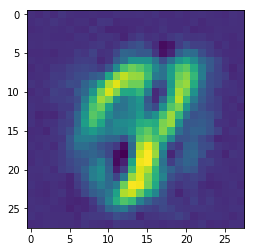

In [39]:
indx = 8
gener = np.zeros([1,10])
gener[:,indx] = 1
print(disOneHot.predict(gener))
decodeTest2 = decoder.predict([[[0, 0.]], gener])
plt.imshow(decodeTest2.reshape(28,28))

## Compare original digitals with the decoding results

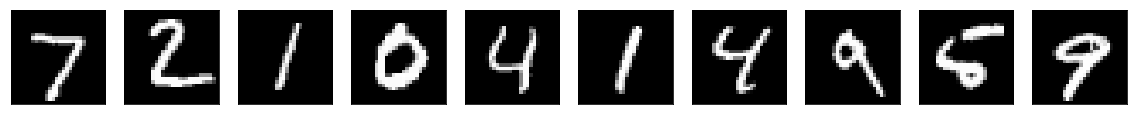

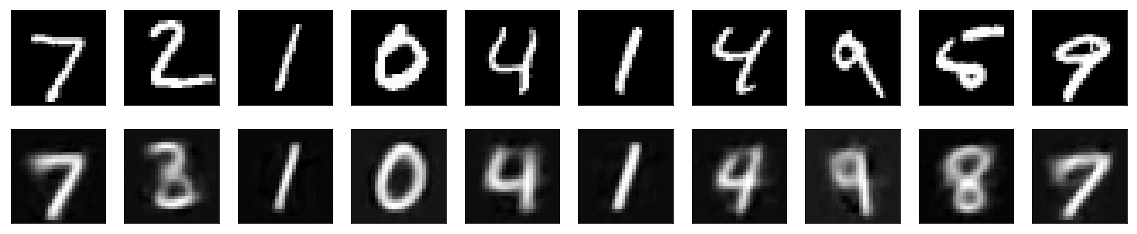

In [13]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

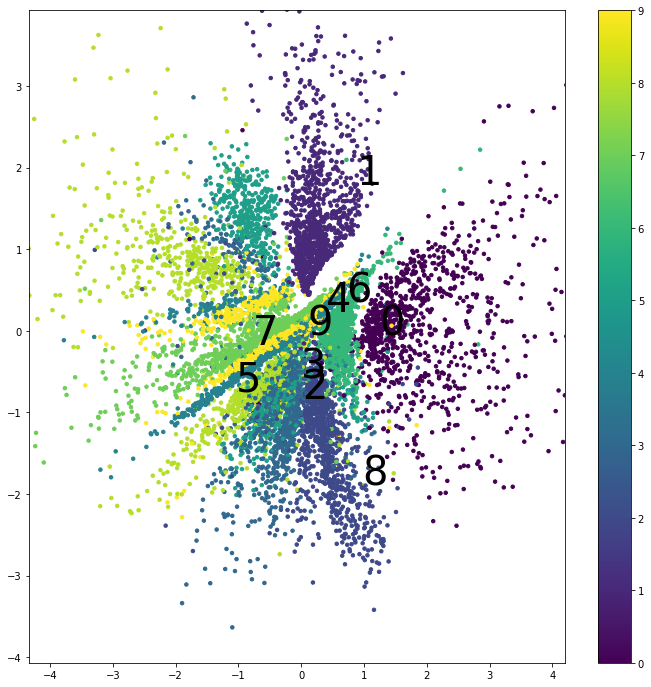

In [14]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

In [15]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[-4.33721217, -4.06841657]])]...

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
plt.imshow(decoder.predict([[0, 0], [1,0,0,0,0,0,0,0,0,0]]).reshape(28,28))

In [ ]:
plt.imshow(decoder.predict([encodeTest[0,:], encodeOneHotTest[0,:]]).reshape(28,28))